In [35]:
import numpy as np
import scipy.stats

import emcee

import matplotlib.pyplot as plt

import matplotlib.style
matplotlib.style.use("bayesian_stats_course_tools.light")

Implement the Metropolis-Hastings sampling routine for $n$ dimensions.

In [59]:
def sample_metropolis_hastings(n, x0,
                               target_distr,
                               sample_transition, transition_prob):
    x0 = np.atleast_1d(x0)
    n_rejected = 0
    n_accepted = 0
    for i in range(n):
        # Sample proposal
        x1 = sample_transition(x0)
        # Compute probabilities of the old and proposed states
        p0 = target_distr.pdf(x0)
        p1 = target_distr.pdf(x1)

        # Compute the transition probabilities
        q01 = transition_prob(x0, x1)
        q10 = transition_prob(x1, x0)

        a = p1/p0 * q01/q10

        u = np.random.uniform(size=1)
        if a >= u:
            # accept, proposed state becomes new state
            n_accepted += 1
            x0 = x1
            yield x1
        else:
            # reject, stay with current state
            n_rejected += 1
            yield x0

    acceptance_rate = n_accepted/(n_accepted + n_rejected)
    print(f"Acceptance rate: {acceptance_rate}")


Set up our target distribution (a bivariate Gaussian).

In [60]:
# Define variances and correlation
sigma_x = 2
sigma_y = 1
rho = 0.7

# Define mean and covariance
mean = np.array([1, 0.5])
cov = np.array([[sigma_x**2, sigma_x*sigma_y*rho],
                [sigma_x*sigma_y*rho, sigma_y**2]])

# Create distribution object
target_distr = scipy.stats.multivariate_normal(mean=mean, cov=cov)

Set up the sampling by defining the proposal (transition) distribution.

In [62]:
proposal_scale = 1.0

def sample_transition(x0):
    # Use an isotropic Gaussian as proposal
    return np.random.normal(loc=x0, scale=proposal_scale)

def transition_prob(x, y):
    # Use an isotropic Gaussian as proposal
    proposal_distr = scipy.stats.multivariate_normal(
        mean=y, cov=proposal_scale*np.eye(y.shape[0])
    )
    return proposal_distr.pdf(x)


Now do the sampling.

In [76]:
x0 = np.array([-5, 7])

samples = [x0]
for x in sample_metropolis_hastings(
        n=2000, x0=x0, 
        target_distr=target_distr,
        sample_transition=sample_transition,
        transition_prob=transition_prob):
    samples.append(x)

samples = np.array(samples)

Acceptance rate: 0.5395


Plot the chain, together with the size of the proposal.

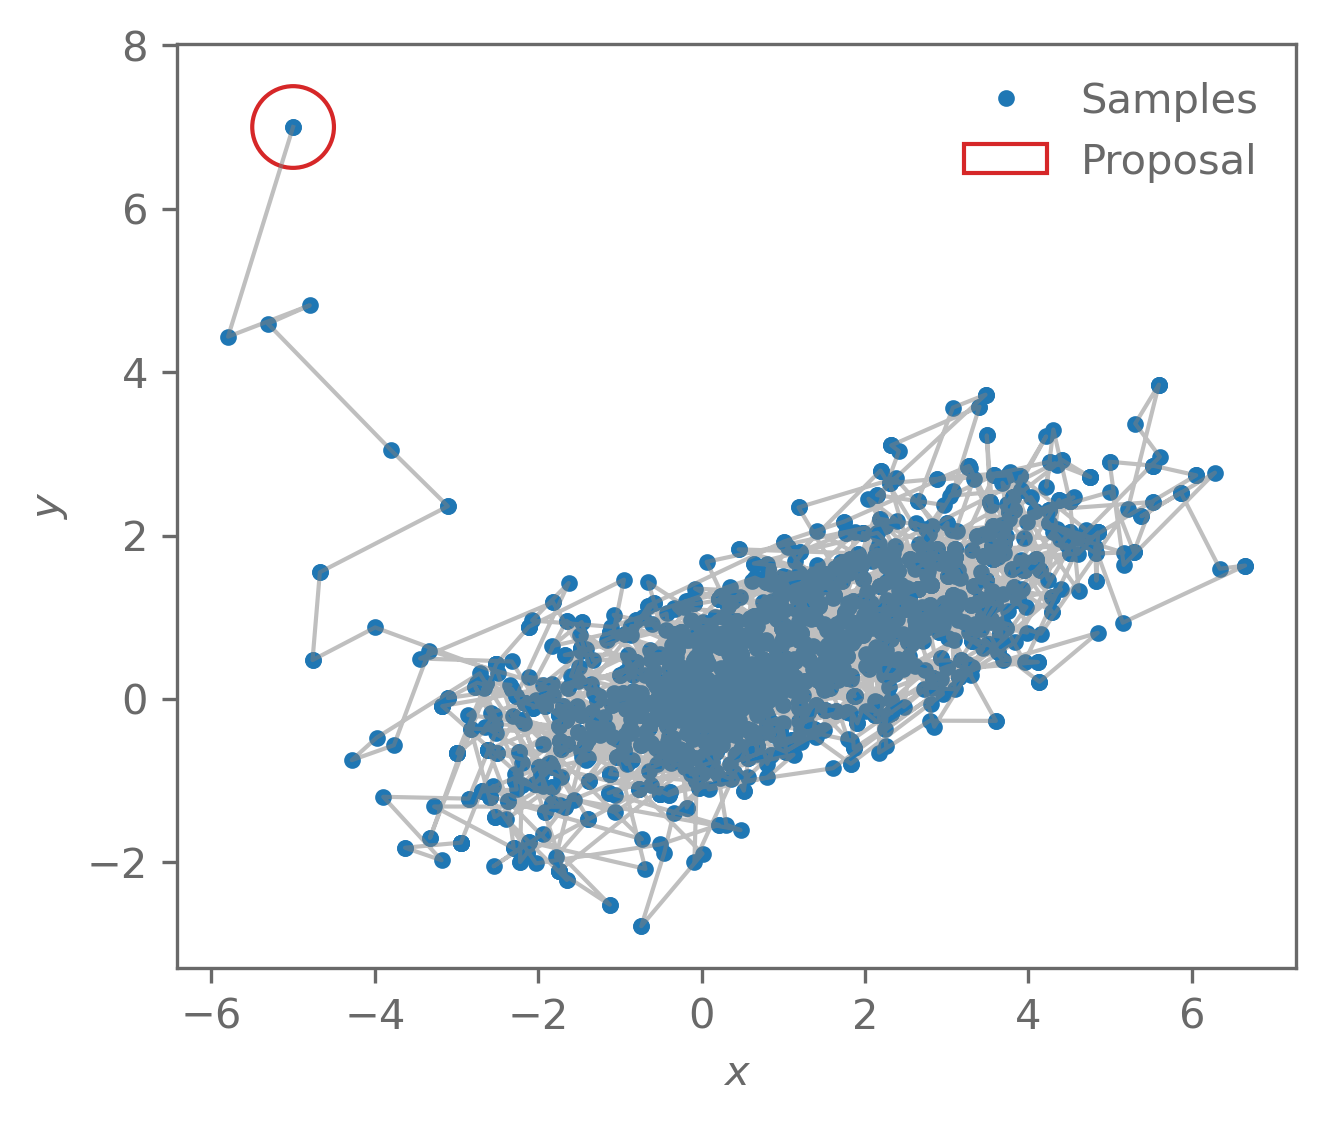

In [77]:
import matplotlib.patches

proposal_contour = matplotlib.patches.Ellipse(
    xy=x0, width=proposal_scale, height=proposal_scale,
    facecolor="none", edgecolor="C3", label="Proposal"
)

fig, ax = plt.subplots()

ax.plot(*samples.T, ".", label="Samples")
ax.plot(*samples.T, lw=1, alpha=0.5, color="grey")
ax.add_patch(proposal_contour)
ax.set_aspect("equal")
ax.legend(frameon=False)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$");

Plot the tracer of the chain (a plot of sample vs time)


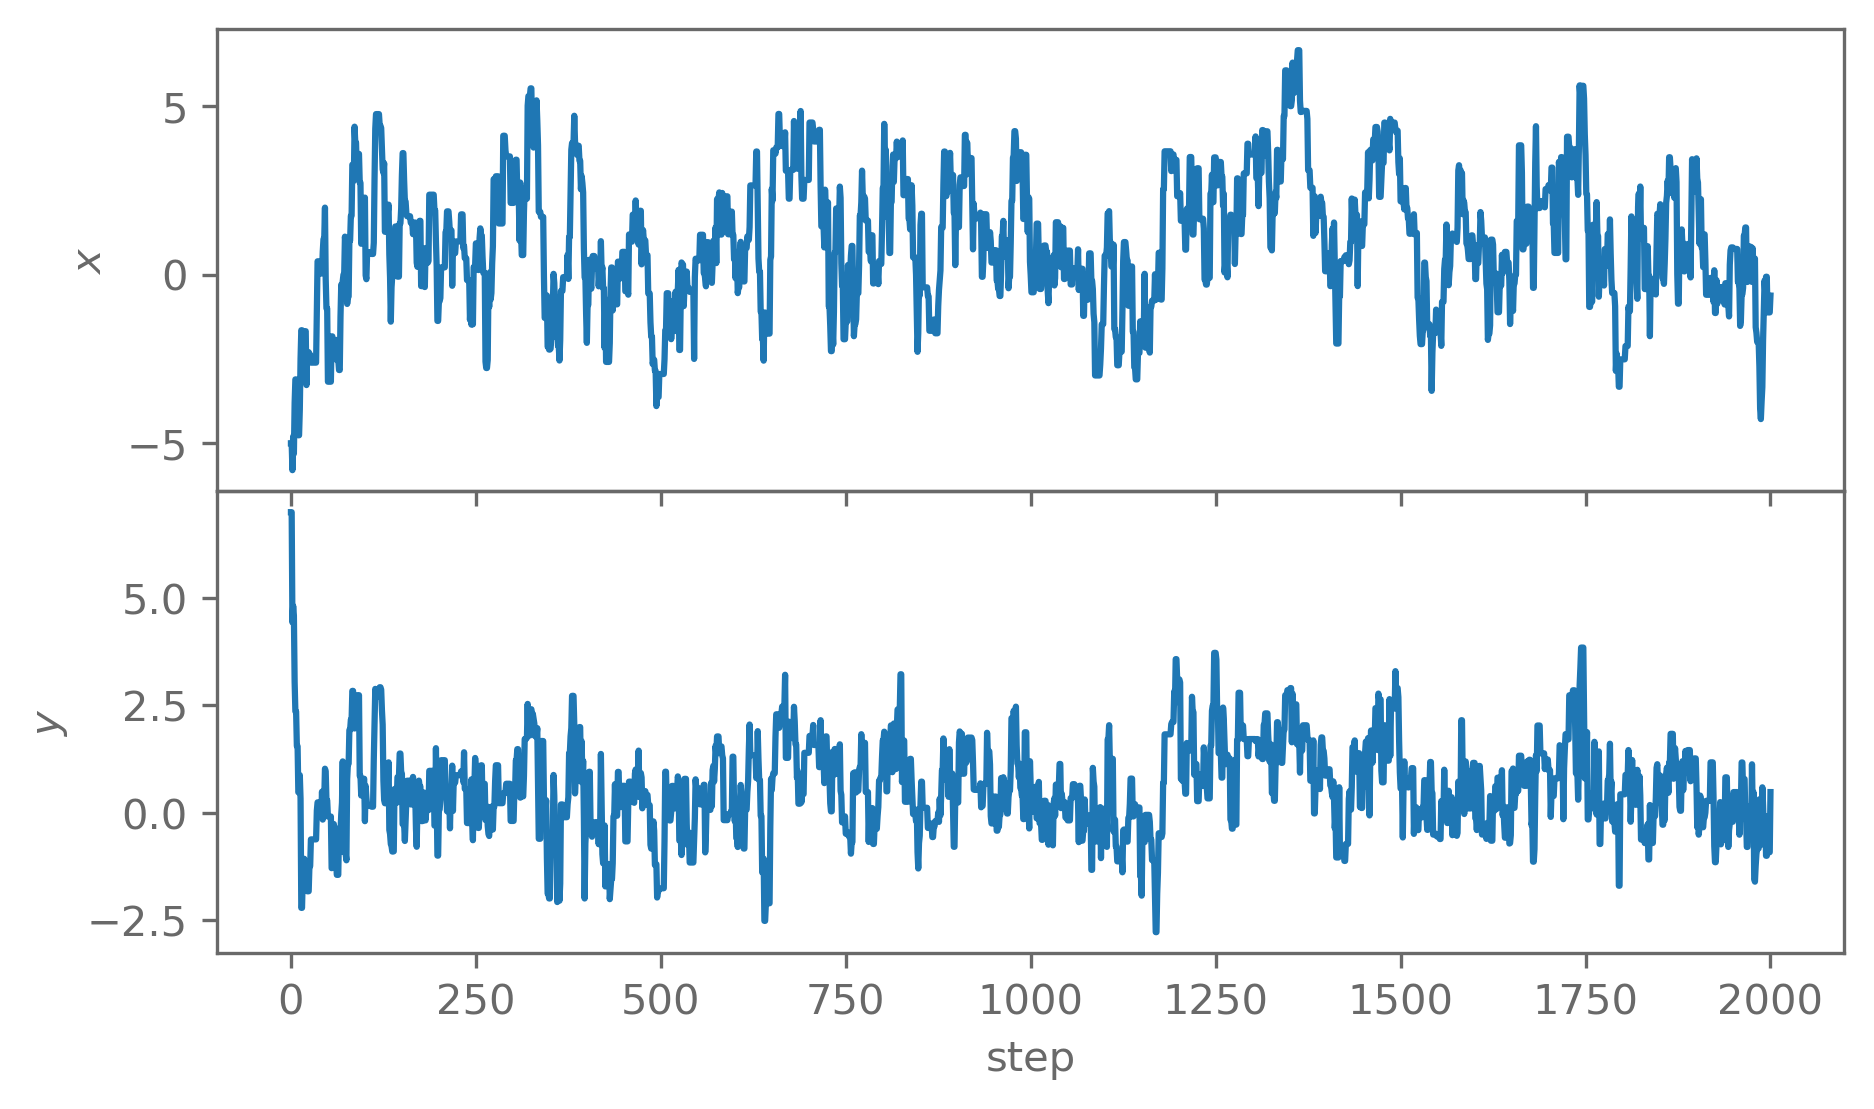

In [78]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0)

ax[0].plot(samples[:,0])
ax[1].plot(samples[:,1])

ax[0].set_ylabel("$x$")
ax[1].set_ylabel("$y$")
ax[1].set_xlabel("step");

Measure the intrated autocorrelation time. This tells us how many steps need to be taken until the samples are approximately independent

In [79]:
# The emcee.autocorr.integrated_time expect the samples to be in 
# shape of (n_samples, n_walker, n_dim). Since we have only one walker here, 
# we need insert an extra dimension

emcee.autocorr.integrated_time(samples[:, None, :])

array([33.12528784, 25.32715261])

In [80]:
# To get rid of the burn-in period, discard the first few autocorrelation times
processed_samples = samples[150:]

# We can also thin out the chain, since only ever 20th or sample is independent
processed_samples = processed_samples[::10]

# This leaves a lot fewer but well-behaved samples
processed_samples.shape

(186, 2)

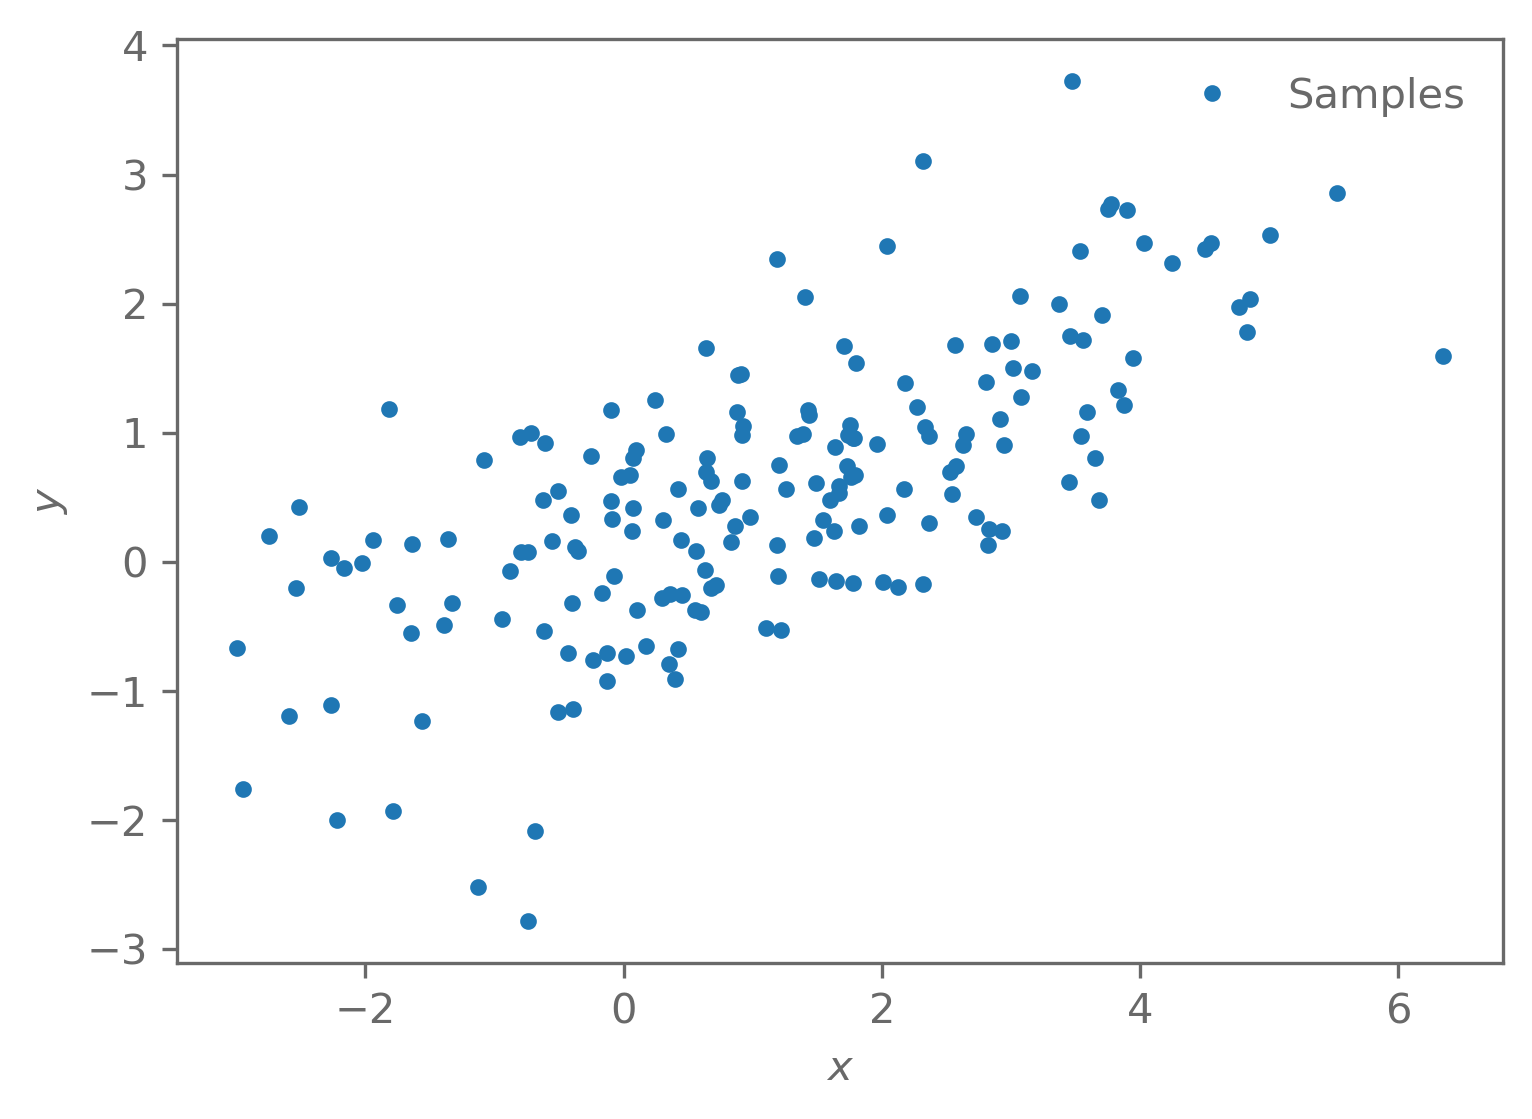

In [81]:
fig, ax = plt.subplots()

ax.plot(*processed_samples.T, ".", label="Samples")
ax.set_aspect("equal")
ax.legend(frameon=False)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$");

Now do the same thing with emcee (https://emcee.readthedocs.io), an affine invariant Markov chain Monte Carlo (MCMC) ensemble sampler.

Paper: https://arxiv.org/abs/1202.3665

In [68]:
# We need to define some extra information for emcee to run
n_param = 2      # Number of parameters that are being sampled
n_walker = 8     # Number of walkers that explore the distribution in parallel
n_step = 2000    # Number of steps to take

# Set up the start point. It needs to have shape (n_walker, n_param)
# We use a big scatter here for illustrative purposes. In a real analysis
# you usually want the walkers to start in a small ball around the peak
# of the distribution
theta_init = np.random.normal(scale=8, size=(n_walker, n_param))

# Set up the sampler
sampler = emcee.EnsembleSampler(
    nwalkers=n_walker,
    ndim=n_param,
    log_prob_fn=target_distr.logpdf    # The log probability of  the target distribution
)
# Run the sampler for n_step steps
state = sampler.run_mcmc(
    initial_state=theta_init,
    nsteps=n_step,
    progress=True
)

100%|██████████| 2000/2000 [00:00<00:00, 3100.22it/s]


Text(0, 0.5, '$y$')

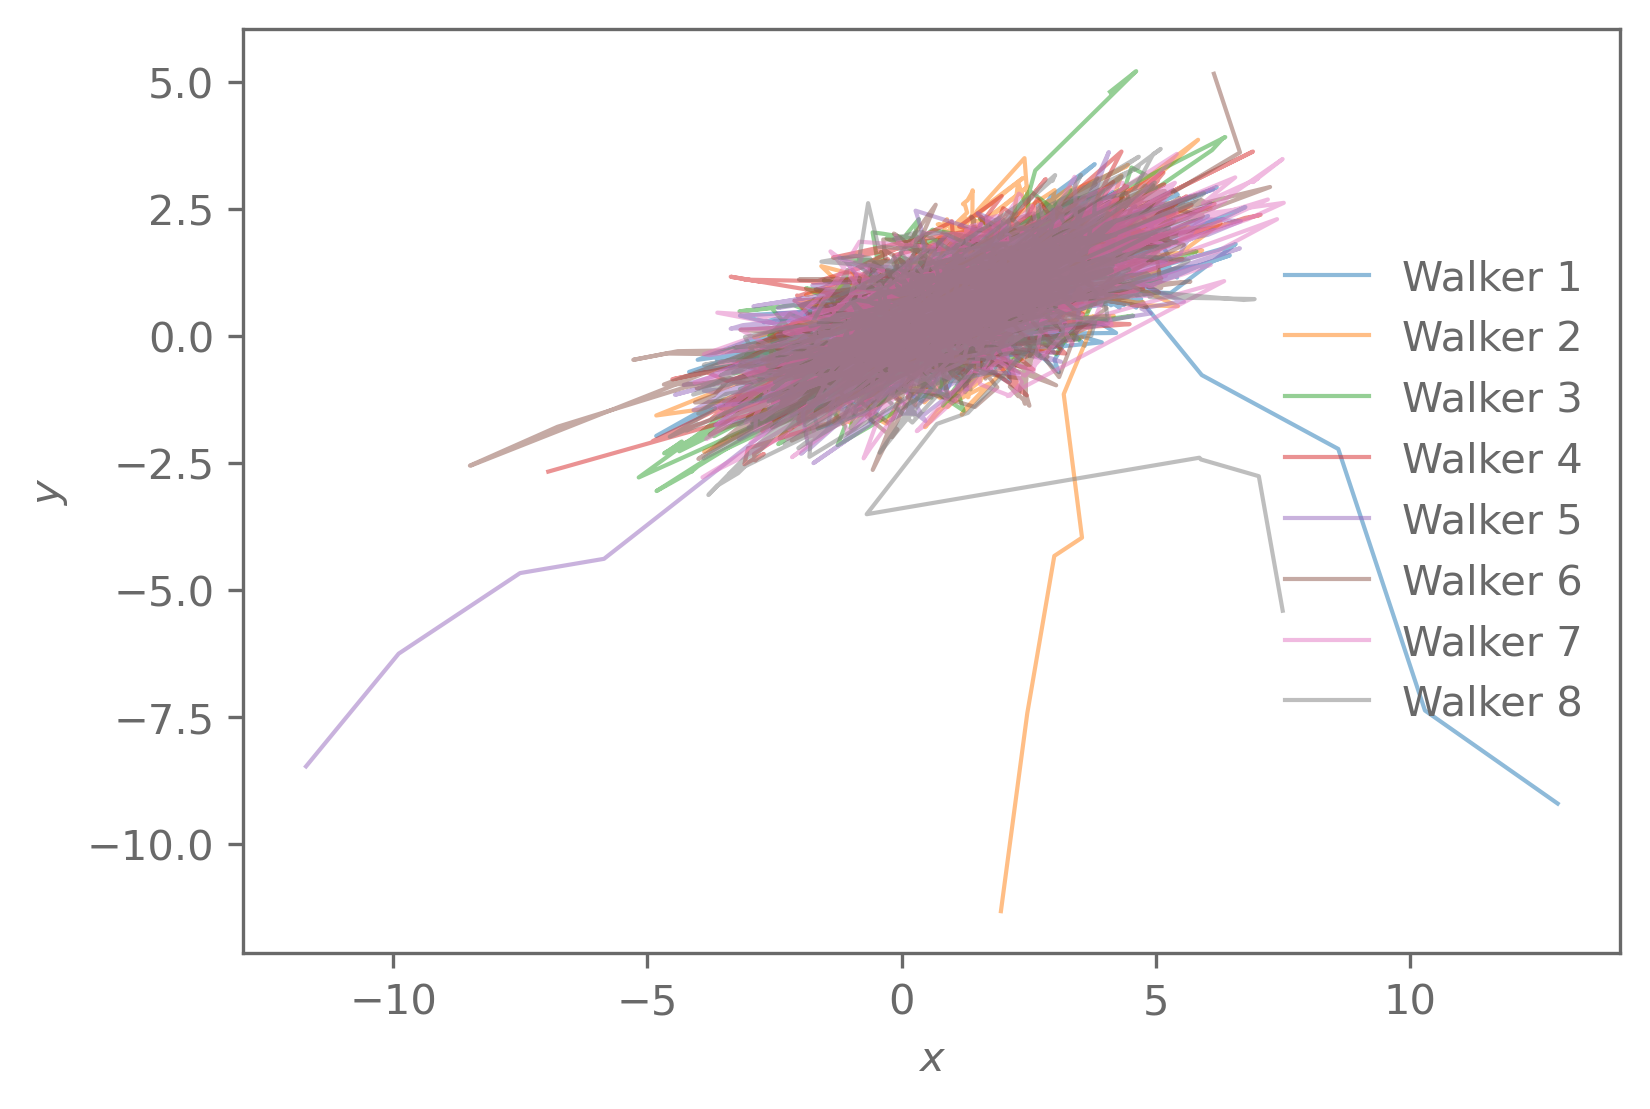

In [69]:
# Get the samples from the chain and plot it
chain = sampler.get_chain()

fig, ax = plt.subplots()
for i in range(n_walker):
    ax.plot(*chain[:, i].T, lw=1, alpha=0.5, color=f"C{i}", label=f"Walker {i+1}")

ax.set_aspect("equal")
ax.legend(frameon=False)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

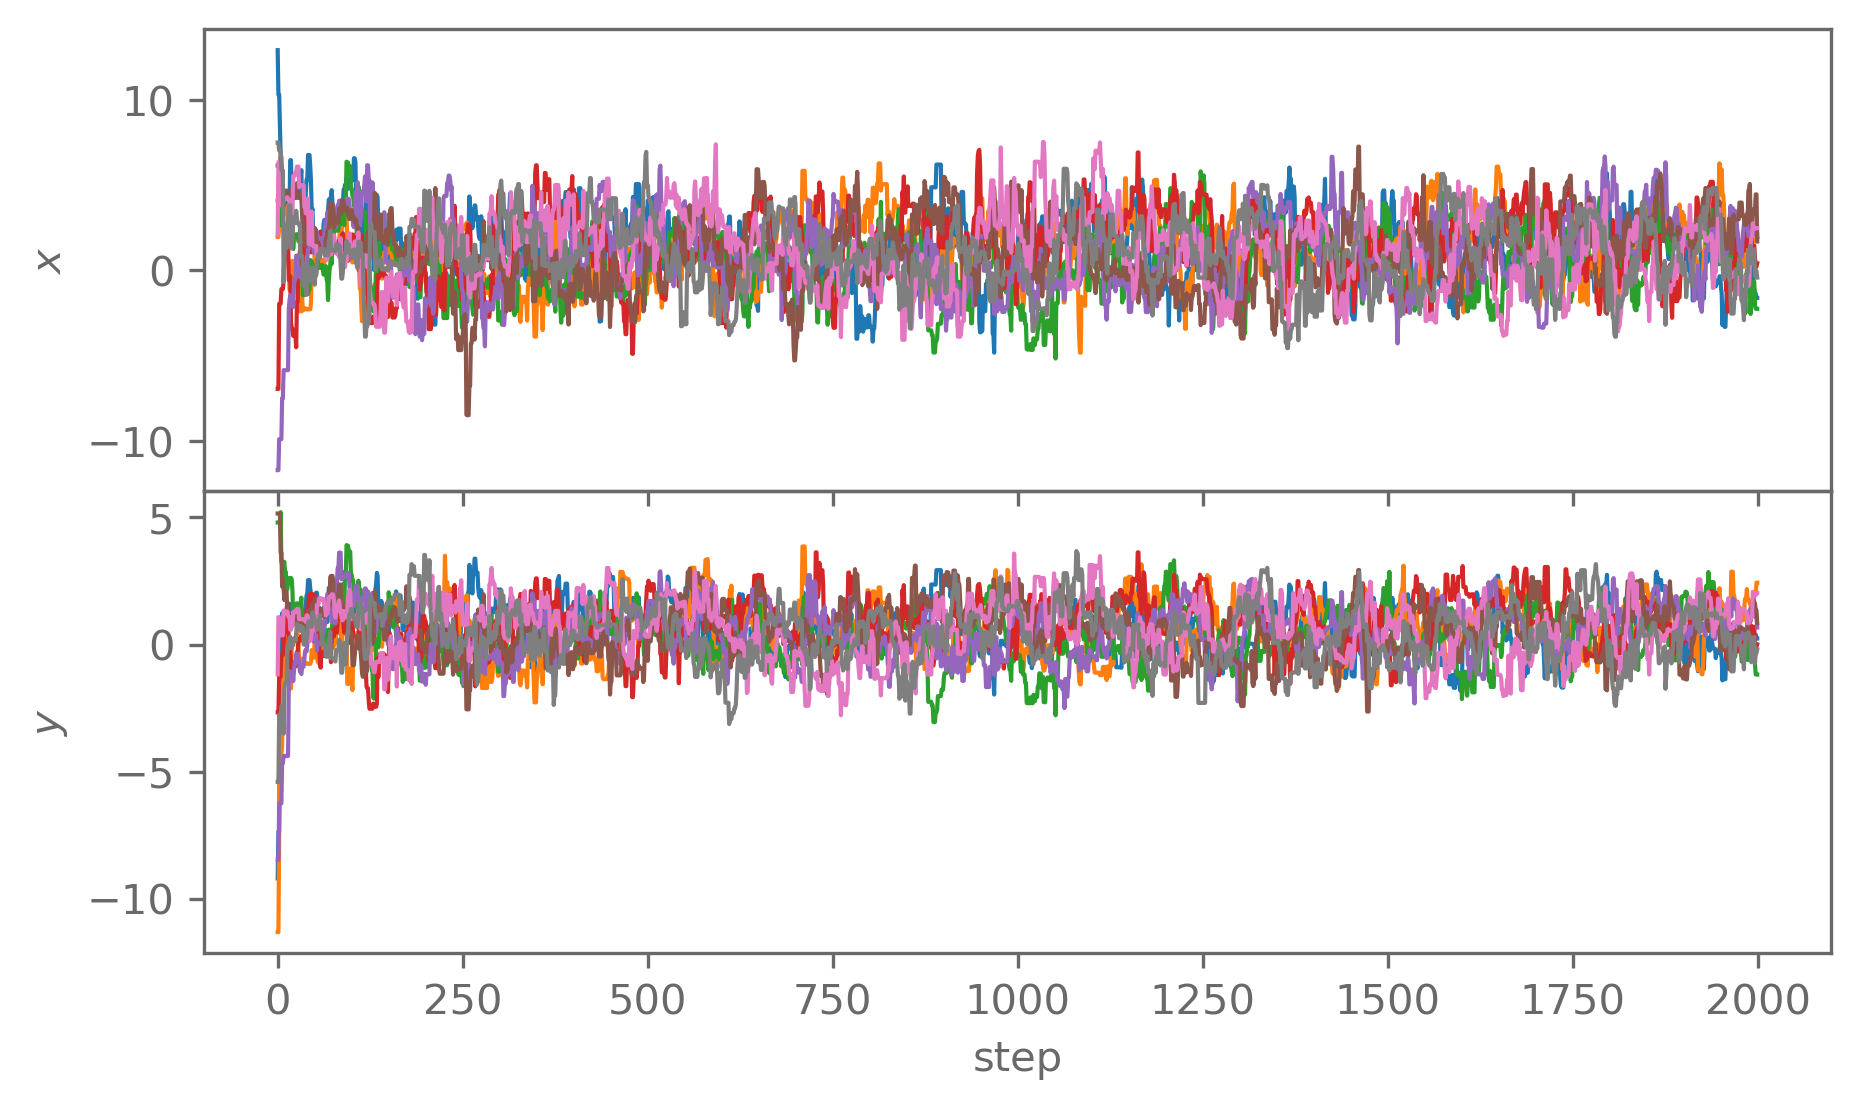

In [70]:
# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i in range(n_walker):
    ax[0].plot(chain[:, i, 0], lw=1, color=f"C{i}")
    ax[1].plot(chain[:, i, 1], lw=1, color=f"C{i}")

ax[0].set_ylabel("$x$")
ax[1].set_ylabel("$y$")
ax[1].set_xlabel("step");

In [71]:
# Measure the autocorrelation time to see
sampler.get_autocorr_time()

array([36.43836535, 35.04277883])

In [73]:
# Get the chain with the burn-in removed, thinned, 
# and flattened (combine the walkers)
chain = sampler.get_chain(discard=200, thin=20, flat=True)

chain.shape

(720, 2)